# Brighter AI Coding Challenge 

### Prompt

In this small task we want you to write a data iterator in Python. A data iterator reads in the raw data and preprocesses the data so that it is well suited for our machine learning models.
In the task we consider a dataset with images which have a resolution of 1920x1080.
The data iterator should read in the original images and randomly select a 512x512 patch in the image.
Once the data iterator processed 32 images, it should yield a batch with 32 patches. So the data iterator yields tensors with the following dimensions, 32 x 3 x 512 x 512.

In [1]:
import numpy as np 
import glob
import random 
import math 
from skimage.io import imread 

#for debugging 
import matplotlib.pyplot as plt

#### Generate some images to validate the generator 

Image 1 will be all ones, 2, all twos etc. for  255 images, [0, 255]. Save in directory `images/`

In [2]:
import cv2
import os 
for i in range(255):
    arr = np.ones((1080, 1920, 3), dtype=np.float32)*i
 
    num = str(0)*(3-len(str(i))) + str(i) 
    cv2.imwrite(os.path.join('images', num+'.jpg'), arr)

## Build the Generator 

In [15]:
def DataGenerator(img_dir, batch_size=32):
    '''Yields tensor of size [batch_size, 3, 512, 512]. 
    
    Each batch contains [batch_size] number of patches of a single image 
    from the img_dir input directory. Note that patches are reshaped from [512, 512, 3] to 
    [3, 512, 512] which may cause color distortion. 
    
    Args:
    img_dir : string
        directory for images, takes form 'dir/' (default None)
    batch_size : int 
        batch size (default 32)
    '''
    
    #get and verify images are in directory 
    img_dir = glob.glob(img_dir + '*')
    assert len(img_dir) > 0, 'no images found, check directory'
    
    num_batches = math.ceil(len(img_dir)/batch_size) #number of batches   
    start, end = 0, batch_size #frame of images in list img_dir
    batch = np.zeros((batch_size, 3, 512, 512)) #init output batch 
  
    for i in range(num_batches):
        img_batch_files = img_dir[start:end]
        
        for j, img_name in enumerate(img_batch_files): 
            img = imread(img_name)
            
            #random patch 
            x_crop = random.randint(0, (img.shape[0]-512))
            y_crop = random.randint(0, (img.shape[1]-512))
            patch = img[x_crop:x_crop+512, y_crop:y_crop+512, :]
#             plt.imshow(patch); plt.show()
            patch = patch.reshape(1, 3, 512, 512)
            batch[j, :, :, :] = patch 
        
        #clip last batch 
        if i == num_batches - 1:
            batch = batch[:j, :, :, :]
            
        yield batch
        
        #increment images for next iteration 
        start += batch_size
        end += batch_size

### Let's verify that it works! 

Since our validation images are just matrices of the same number, corresponding with the filename (example 012.jpg is a [1920x1080x3] matrix of all 12's), and our batch is a tensor of 32 images, then the mean of each batch should increase by 32 at each iteration. This is how we can check if the generator is working. Additionally, since there are 255 images and a batch size of 32, we should expect to get 8 iterations. 

In [12]:
#create the generator 
gen = DataGenerator('images/', 32)

#print out the generator output until the StopIteration error
try: 
    for i in range(100): 
        batch = next(gen)
        print ('iteration {}, batch size: {}, batch mean: {}'.format(i, batch.shape, np.mean(batch)))

except StopIteration: 
    print ('reached end of image data')

iteration 0, batch size: (32, 3, 512, 512), batch mean: 15.5
iteration 1, batch size: (32, 3, 512, 512), batch mean: 47.5
iteration 2, batch size: (32, 3, 512, 512), batch mean: 79.5
iteration 3, batch size: (32, 3, 512, 512), batch mean: 111.5
iteration 4, batch size: (32, 3, 512, 512), batch mean: 143.5
iteration 5, batch size: (32, 3, 512, 512), batch mean: 175.5
iteration 6, batch size: (32, 3, 512, 512), batch mean: 207.5
iteration 7, batch size: (30, 3, 512, 512), batch mean: 238.5
reached end of image data


One thing to note with this iterator is that if the amount of images in the directory is not exactly divisible by the batch size, then the last batch will be clipped to avoid recycling the remainder of images (ex. 2 images clipped if the last batch is size 30). This is why the last batch yeilds a tensor of size [30, 3, 512, 512].

And here just a check of the actual output images (uncomment the matplotlib plotting line).

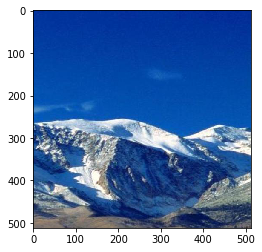

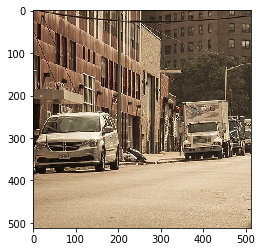

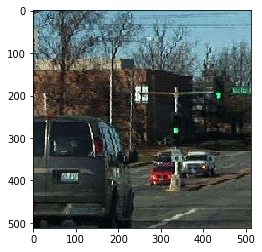

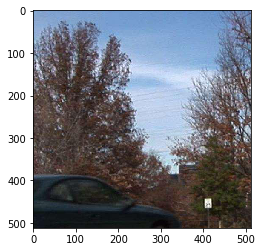

iteration 0, batch size: (3, 3, 512, 512), batch mean: 96.70158979627821
reached end of image data


In [17]:
#create the generator 
gen = DataGenerator('real/', 32)

#print out the generator output until the StopIteration error
try: 
    for i in range(100): 
        batch = next(gen)
        print ('iteration {}, batch size: {}, batch mean: {}'.format(i, batch.shape, np.mean(batch)))

except StopIteration: 
    print ('reached end of image data')

Overall, this works fine as a base-model iterator, but there are ways to make it more robust. Most importantly, this iterator will fail with GPUs because the GPU will try to share the `__next__` method across many parallel cores. A generator iteration cannot be stopped and resumed by multiple threads running at the same time, so we will see the error `ValueError: generator already executing`. The solution is to lock and release the thread with each iteration of the generator. 

A second improvement is to add data augmentation technqiues. Though we are already cropping random patches of the image, we can add vertical flips, rotation, and shear. This will create more subtle variation in the data which should help the machine learning model generalize well. 

In [13]:
#for GPU support 
import threading

#for image augmentation 
from skimage import transform

In [ ]:
'''Augment the image 

1. random angle rotation (+crop out black/resize)
2. random flip about y-axis 
3. random shear 
'''

def rotate(image, angle):
    #random angle between given range
    angle_jitter = (random.random()*angle*2)-angle 
    rotated_image = transform.rotate(image, angle)
    
    #length of pixels lost from rotation
    pix = angle*14
    rotated_image = rotated_image[pix:-pix, :, :]
    rotated_image = transform.resize(rotated_image, image.shape)
    return rotated_image

def shear(image, shear):
    
    # create shear_val from [-shear, shear] 
    shear_val = random.random()*shear*2-shear 
    
    # create Afine transform
    afine = transform.AffineTransform(shear=shear_val)
    
    # apply transform to image data
    sheared_image = transform.warp(image, inverse_map=afine)
    
    #crop out black 
    sheared_image = sheared_image[:, 100:-100, :]
    sheared_image = transform.resize(sheared_image, image.shape)
    return sheared_image

def flip(image):
    flip_prob = random.randint(0, 1) #50/50
    flipped_image = image[::-1] if flip_prob == 1 else image
    return flipped_image

    
    
def DataGenerator(img_dir, batch_size=32, augment=False, angle=12, shear_angle=0.12):
    '''Yields tensor of size [batch_size, 3, 512, 512]. GPU compatible. 
    
    Each batch contains [batch_size] number of patches of a single image 
    from the img_dir input directory. Note that patches are reshaped from [512, 512, 3] to 
    [3, 512, 512] which may cause color distortion.
    
    Additionally it augments the image at each iteration with: random angle rotation,
    random flip about y-axis, random shear. 
    
    Args:
    img_dir : string
        directory for images, takes form 'dir/' (default None)
    batch_size : int 
        batch size (default 32)
    augment : bool 
        if true, augments the image (default False)
    angle : int 
        angle range to rotate about - [-angle, angle] (default 12)
    shear : float 
        shear angle range - [-shear, shear](default 0.12)
    '''
    
    #get and verify images are in directory 
    img_dir = glob.glob(img_dir + '*')
    assert len(img_dir) > 0, 'no images found, check directory'
    
    num_batches = math.ceil(len(img_dir)/batch_size) #number of batches    
    start, end = 0, batch_size #frame of images in list img_dir
    batch = np.zeros((batch_size, 3, 512, 512)) #init output batch 
    
    #lock and release threads at iteration execution 
    with threading.Lock():      
        for i in range(num_batches):
            img_batch_files = img_dir[start:end]

            for j, img_name in enumerate(img_batch_files): 
                img = imread(img_name)
                
                #image augmentation 
                if augment: 
                    img = rotate(img, angle)
                    img = shear(img, shear_angle)
                    img = flip(img)

                #random patch 
                x_crop = random.randint(0, (img.shape[0]-512))
                y_crop = random.randint(0, (img.shape[1]-512))
                patch = img[x_crop:x_crop+512, y_crop:y_crop+512, :]
    #             plt.imshow(patch); plt.show()
                patch = patch.reshape(1, 3, 512, 512)
                batch[j, :, :, :] = patch 
            
            #clip last batch 
            if i == num_batches - 1:
                batch = batch[:j, :, :, :]
                
            yield batch

            #increment images for next iteration 
            start += batch_size
            end += batch_size

In [ ]:
#create the generator 
gen = DataGenerator('images/', batch_size=32, augment=True, angle=12, shear_angle=0.12)

#print out the generator output until the StopIteration error
try: 
    for i in range(100): 
        batch = next(gen)
        print ('iteration {}, batch size: {}'.format(i, batch.shape))

except StopIteration: 
    print ('reached end of image data')

iteration 0, batch size: (32, 3, 512, 512)
iteration 1, batch size: (32, 3, 512, 512)
iteration 2, batch size: (32, 3, 512, 512)
iteration 3, batch size: (32, 3, 512, 512)
iteration 4, batch size: (32, 3, 512, 512)
iteration 5, batch size: (32, 3, 512, 512)


The augmentation causes the processing time to be greater. This marginally added time is probably negligible when using for machine/deep learning, and a GPU should speed up the augmentation. But if there is enough training data, then leaving the `augment` setting to `False` should be ok. Additionally, the augmentation should always be set to `False` for Validation and Test sets, since we want to get an accuracte metric on a machine learning model that is tested on this dataset. 